In [1]:
import numpy as np
import librosa
import librosa.display
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

### Splitting data

In [4]:
random.seed(10)

# Data files
data_path_pre = 'wetvoice/extractedMPTs/pre swallow/**'
data_files_pre = [x for x in glob.glob(data_path_pre) if '.wav' in x and 'android' not in x]

data_path_post = 'wetvoice/extractedMPTs/post swallow/**'
data_files_post = [x for x in glob.glob(data_path_post) if '.wav' in x and 'android' not in x]

ids = [x.split('/')[-1].split('_post')[0] for x in data_files_post]

train_files = [x for x in data_files_post if x.split('/')[-1].split('_post')[0] in ids[:95]]
# val_files = [x for x in data_files_pre if x.split('/')[-1].split('_pre')[0] in ids[77:87]]
# test_files = [x for x in data_files_pre if x.split('/')[-1].split('_pre')[0] in ids[87:]]

len(train_files)

95

#### Labels

In [5]:
df = pd.read_excel('audio file numbers and aspiration values.xlsx')
df.head()

,Audio File Name,Aspiration
0,203,No
1,201,No
2,200,No
3,199,Yes
4,198,No


In [7]:
train_labels = [df[df['Audio File Name']==int(i.split('/')[-1].split('_post')[0])]['Aspiration  '].values[0]
                for i in train_files]
train_labels = [1 if x == 'Yes' else 0 for x in train_labels]
len(train_labels)

95

In [9]:
def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)
    
    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    
    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Temporal features
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    
    # Statistical features across frames
    mean_centroid = np.mean(spectral_centroids)
    std_centroid = np.std(spectral_centroids)
    mean_rolloff = np.mean(spectral_rolloff)
    std_rolloff = np.std(spectral_rolloff)
    mean_bandwidth = np.mean(spectral_bandwidth)
    std_bandwidth = np.std(spectral_bandwidth)
    mean_chroma = np.mean(chroma_stft)
    std_chroma = np.std(chroma_stft)
    mean_zcr = np.mean(zero_crossing_rate)
    std_zcr = np.std(zero_crossing_rate)
    
    # Combine all features into one feature vector
    features = np.array([
        mean_centroid, std_centroid, mean_rolloff, std_rolloff, mean_bandwidth, std_bandwidth,
        mean_chroma, std_chroma, mean_zcr, std_zcr
    ])
    
    return features


audio_paths_a = train_files
audio_paths_b = [x.replace('post', 'pre') for x in train_files]

features = []
for path_a, path_b in zip(audio_paths_a, audio_paths_b):
    features_a = extract_features(path_a)
    features.append(features_a)

features = np.array(features)
labels = np.array(train_labels)  

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42,  stratify=labels)

## TSNE

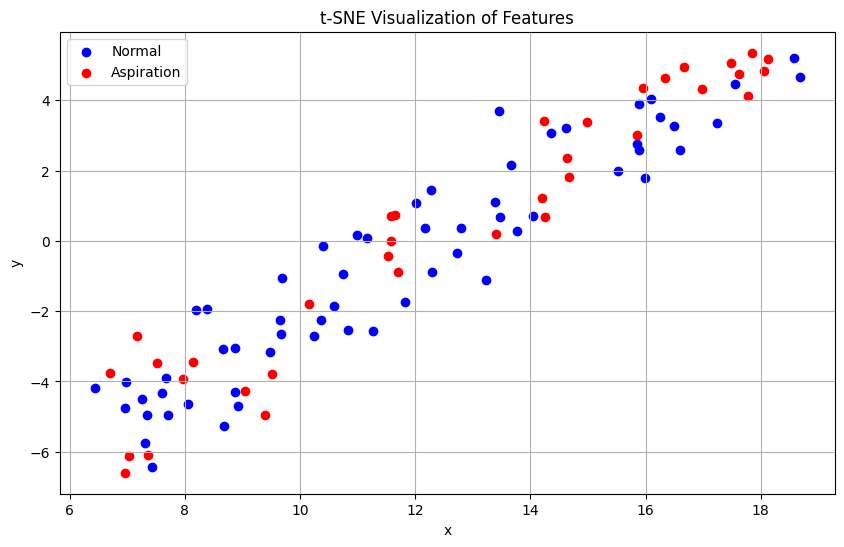

AttributeError: module 'matplotlib' has no attribute 'pyplot'

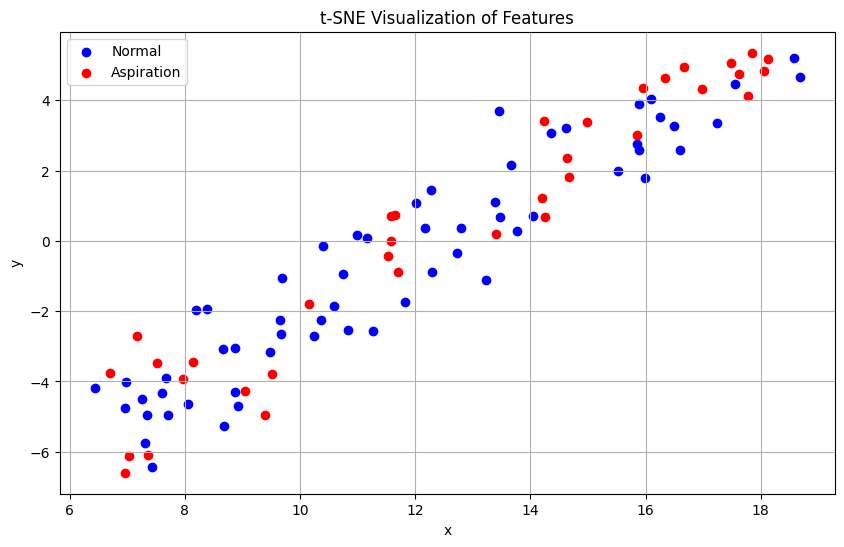

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [10]:
tsne = TSNE(n_components=2, random_state=42)

features_2d = tsne.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 6))
colors = ['blue', 'red']  # Color for each class

clmap = {0: 'Normal' , 1: "Aspiration"}
# Plot each class
for label, color in zip([0, 1], colors):
    plt.scatter(features_2d[labels == label, 0], features_2d[labels == label, 1], c=color, label=f'{clmap[label]}')

plt.title('t-SNE Visualization of Features')
plt.xlabel('x')
plt.ylabel('y')
plt.legend() 
plt.grid(True)
plt.show()